# 1.1 Information Extraction Architecture
![Image](images/ie-architecture.png)

In [1]:
import nltk, re, pprint

# default sentence segmenter, word tokenizer, and part-of-speech tagger 
def ie_preprocess(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]

# 2 Chunking
- Smaller boxes show the word-level tokenization and part-of-speech tagging
- Each of these larger boxes is called a chunk
- Like tokenization, which omits whitespace, chunking usually selects a subset of the tokens. 
- Also like tokenization, the pieces produced by a chunker do not overlap in the source text.

![Image](images/chunk-segmentation.png)

# 2.1 Noun Phrase (NP) Chunking

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


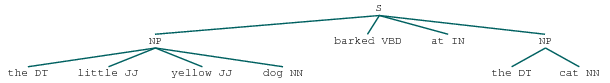

In [2]:
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]

# single regular-expression rule
grammar = "NP: {<DT>?<JJ>*<NN>}"

# chunk parser
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
print(result)

# result.draw()
result

![Image](images/ch07-tree-1.png)

# 2.3 Chunking with Regular Expressions

In [3]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
      {<NNP>+}                # chunk sequences of proper nouns
"""
cp = nltk.RegexpParser(grammar)
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"),
                 ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

print(cp.parse(sentence))

(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PP$ long/JJ golden/JJ hair/NN))


# 2.4 Exploring Text Corpora
- Extract phrases matching a particular sequence of part-of-speech tags

In [4]:
cp = nltk.RegexpParser('CHUNK: {<V.*> <TO> <V.*>}')
brown = nltk.corpus.brown

result = []
for sent in brown.tagged_sents():
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK':
            result.append(subtree)

result[:10]

[Tree('CHUNK', [('combined', 'VBN'), ('to', 'TO'), ('achieve', 'VB')]),
 Tree('CHUNK', [('continue', 'VB'), ('to', 'TO'), ('place', 'VB')]),
 Tree('CHUNK', [('serve', 'VB'), ('to', 'TO'), ('protect', 'VB')]),
 Tree('CHUNK', [('wanted', 'VBD'), ('to', 'TO'), ('wait', 'VB')]),
 Tree('CHUNK', [('allowed', 'VBN'), ('to', 'TO'), ('place', 'VB')]),
 Tree('CHUNK', [('expected', 'VBN'), ('to', 'TO'), ('become', 'VB')]),
 Tree('CHUNK', [('expected', 'VBN'), ('to', 'TO'), ('approve', 'VB')]),
 Tree('CHUNK', [('expected', 'VBN'), ('to', 'TO'), ('make', 'VB')]),
 Tree('CHUNK', [('intends', 'VBZ'), ('to', 'TO'), ('make', 'VB')]),
 Tree('CHUNK', [('seek', 'VB'), ('to', 'TO'), ('set', 'VB')])]

# 2.5 Chinking
- Chink is a sequence of tokens that is not included in a chunk
- Chinking is the process of removing a sequence of tokens from a chunk

In [5]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<VBD|IN>+{      # Chink sequences of VBD and IN
  """

sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
       ("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]

cp = nltk.RegexpParser(grammar)
cp

<chunk.RegexpParser with 1 stages>

In [6]:
print(cp.parse(sentence))

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


# 2.6 Representing Chunks: Tags vs Trees
- Chunk structures can be represented using either tags or trees. 
- The most widespread file representation uses IOB tags. 
    1. 3 special chunk tags, I (inside), O (outside), or B (begin). 
    2. A token is tagged as B if it marks the beginning of a chunk. 
    3. Subsequent tokens within the chunk are tagged I. All other tokens are tagged O
   
![Image](images/chunk-tagrep.png)

![Image](images/chunk-treerep.png)

# 3.1 Reading IOB Format and the CoNLL 2000 Corpus

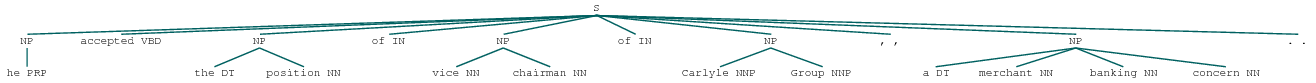

In [7]:
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''

# nltk.chunk.conllstr2tree(text, chunk_types=['NP']).draw()
nltk.chunk.conllstr2tree(text, chunk_types=['NP'])

![Image](images/ch07-tree-2.png)

In [8]:
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


In [9]:
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


# 3.2 Simple Evaluation and Baselines

In [10]:
from nltk.corpus import conll2000
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

# its precision, recall, and f-measure are all zero tagger => did not find any chunks
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


In [11]:
# looks for tags beginning with letters that are characteristic of noun phrase tags (e.g. CD, DT, and JJ)
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


In [12]:
# uses a unigram tagger to label sentences with chunk tags
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        """
        It first converts training data to a form that is suitable for training the tagger
        It then uses that converted training data to train a unigram tagger, and stores it in self.tagger
        """
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        """
        It takes a tagged sentence as its input, 
        and begins by extracting the part-of-speech tags from that sentence. 
        It then tags the part-of-speech tags with IOB chunk tags, using the self.tagger 
        Next, it extracts the chunk tags, and combines them with the original sentence, 
        to yield conlltags. 
        Finally, it uses conlltags2tree to convert the result back into a chunk tree
        """
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [13]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [14]:
postags = sorted(set(pos for sent in train_sents
                     for (word,pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


1. Most punctuation marks occur outside of NP chunks, with the exception of `#` and `$`, both of which are used as currency markers.
2. It has also found that determiners (DT) and possessives (PRP\$ and WP\$) occur at the beginnings of NP chunks, while noun types (NN, NNP, NNPS, NNS) mostly occur inside of NP chunks

In [15]:
# different from UnigramChunker for line 6
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [16]:
bigram_chunker = BigramChunker(train_sents)
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


# 3.3 Training Classifier-Based Chunkers

In [17]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):
    # Almost identical to the ConsecutivePosTagger class from 1.6 
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                # The only two differences are that it calls a different feature extractor
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        # MaxentClassifier rather than a NaiveBayesClassifier
        self.classifier = nltk.MaxentClassifier.train(train_set, algorithm='megam', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

Don't include example for this due to error: "NLTK was unable to find the megam file"

# 4.1 Building Nested Structure with Cascaded Chunkers
- Build chunk structures of arbitrary depth

In [18]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """

sentence = [("John", "NNP"), ("thinks", "VBZ"), ("Mary", "NN"),
    ("saw", "VBD"), ("the", "DT"), ("cat", "NN"), ("sit", "VB"),
    ("on", "IN"), ("the", "DT"), ("mat", "NN")]

In [19]:
cp = nltk.RegexpParser(grammar, loop=2)
print(cp.parse(sentence))

(S
  (NP John/NNP)
  thinks/VBZ
  (CLAUSE
    (NP Mary/NN)
    (VP
      saw/VBD
      (CLAUSE
        (NP the/DT cat/NN)
        (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))))


# 4.2 Trees
![Image](images/ch07-tree-3.png)

In [20]:
tree1 = nltk.Tree('NP', ['Alice'])
print(tree1)

tree2 = nltk.Tree('NP', ['the', 'rabbit'])
print(tree2)

tree3 = nltk.Tree('VP', ['chased', tree2])
tree4 = nltk.Tree('S', [tree1, tree3])
print(tree4)

(NP Alice)
(NP the rabbit)
(S (NP Alice) (VP chased (NP the rabbit)))


(VP chased (NP the rabbit))
VP
['Alice', 'chased', 'the', 'rabbit']
rabbit


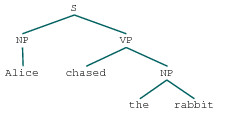

In [21]:
print(tree4[1])

print(tree4[1].label())

print(tree4.leaves())

print(tree4[1][1][1])

# tree4.draw()
tree4

# 4.3 Tree Traversal

( S ( NP Alice ) ( VP chased ( NP the rabbit ) ) ) 

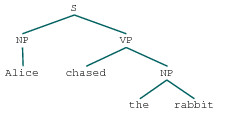

In [22]:
def traverse(t):
    try:
        t.label()
    except AttributeError:
        print(t, end=" ")
    else:
        # Now we know that t.node is defined
        print('(', t.label(), end=" ")
        for child in t:
            traverse(child)
        print(')', end=" ")

t = nltk.Tree.fromstring('(S (NP Alice) (VP chased (NP the rabbit)))')
traverse(t)
t

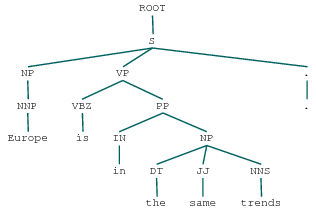

In [23]:
import nltk

s = '(ROOT (S (NP (NNP Europe)) (VP (VBZ is) (PP (IN in) (NP (DT the) (JJ same) (NNS trends)))) (. .)))'
t2 = nltk.tree.Tree.fromstring(s)

def traverse_tree(tree):
    # print("tree:", tree)
    for subtree in tree:
        if type(subtree) == nltk.tree.Tree:
            traverse_tree(subtree)

traverse_tree(t2)
t2

# 5 Named Entity Recognition
- NLTK provides a classifier that has already been trained to recognize named entities, accessed with the function nltk.ne_chunk(). 
- If we set the parameter binary=True, then named entities are just tagged as  NE; otherwise, the classifier adds category labels such as PERSON, ORGANIZATION, and GPE

In [24]:
sent = nltk.corpus.treebank.tagged_sents()[22]
print(nltk.ne_chunk(sent, binary=True))

(S
  The/DT
  (NE U.S./NNP)
  is/VBZ
  one/CD
  of/IN
  the/DT
  few/JJ
  industrialized/VBN
  nations/NNS
  that/WDT
  *T*-7/-NONE-
  does/VBZ
  n't/RB
  have/VB
  a/DT
  higher/JJR
  standard/NN
  of/IN
  regulation/NN
  for/IN
  the/DT
  smooth/JJ
  ,/,
  needle-like/JJ
  fibers/NNS
  such/JJ
  as/IN
  crocidolite/NN
  that/WDT
  *T*-1/-NONE-
  are/VBP
  classified/VBN
  *-5/-NONE-
  as/IN
  amphobiles/NNS
  ,/,
  according/VBG
  to/TO
  (NE Brooke/NNP)
  T./NNP
  Mossman/NNP
  ,/,
  a/DT
  professor/NN
  of/IN
  pathlogy/NN
  at/IN
  the/DT
  (NE University/NNP)
  of/IN
  (NE Vermont/NNP College/NNP)
  of/IN
  (NE Medicine/NNP)
  ./.)


In [25]:
print(nltk.ne_chunk(sent))

(S
  The/DT
  (GPE U.S./NNP)
  is/VBZ
  one/CD
  of/IN
  the/DT
  few/JJ
  industrialized/VBN
  nations/NNS
  that/WDT
  *T*-7/-NONE-
  does/VBZ
  n't/RB
  have/VB
  a/DT
  higher/JJR
  standard/NN
  of/IN
  regulation/NN
  for/IN
  the/DT
  smooth/JJ
  ,/,
  needle-like/JJ
  fibers/NNS
  such/JJ
  as/IN
  crocidolite/NN
  that/WDT
  *T*-1/-NONE-
  are/VBP
  classified/VBN
  *-5/-NONE-
  as/IN
  amphobiles/NNS
  ,/,
  according/VBG
  to/TO
  (PERSON Brooke/NNP T./NNP Mossman/NNP)
  ,/,
  a/DT
  professor/NN
  of/IN
  pathlogy/NN
  at/IN
  the/DT
  (ORGANIZATION University/NNP)
  of/IN
  (PERSON Vermont/NNP College/NNP)
  of/IN
  (GPE Medicine/NNP)
  ./.)


# 6 Relation Extraction
- Once named entities have been identified in a text, we then want to extract the relations that exist between them
- (X, α, Y), where X and Y are named entities of the required types, and α is the string of words that intervenes between X and Y

In [26]:
IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,
                                     corpus='ieer', pattern = IN):
        print(nltk.sem.rtuple(rel))

[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


In [27]:
from nltk.corpus import conll2002

vnv = """
(
is/V|    # 3rd sing present and
was/V|   # past forms of the verb zijn ('be')
werd/V|  # and also present
wordt/V  # past of worden ('become)
)
.*       # followed by anything
van/Prep # followed by van ('of')
"""

VAN = re.compile(vnv, re.VERBOSE)

for doc in conll2002.chunked_sents('ned.train'):
    for r in nltk.sem.extract_rels('PER', 'ORG', doc,
                                   corpus='conll2002', pattern=VAN):
        print(nltk.sem.clause(r, relsym="VAN"))

VAN("cornet_d'elzius", 'buitenlandse_handel')
VAN('johan_rottiers', 'kardinaal_van_roey_instituut')
VAN('annie_lennox', 'eurythmics')


# 7 Summary
- Information extraction systems search large bodies of unrestricted text for specific types of entities and relations, and use them to populate well-organized databases. These databases can then be used to find answers for specific questions.
- The typical architecture for an information extraction system begins by segmenting, tokenizing, and part-of-speech tagging the text. The resulting data is then searched for specific types of entity. Finally, the information extraction system looks at entities that are mentioned near one another in the text, and tries to determine whether specific relationships hold between those entities.
- Entity recognition is often performed using chunkers, which segment multi-token sequences, and label them with the appropriate entity type. Common entity types include ORGANIZATION, PERSON, LOCATION, DATE, TIME, MONEY, and GPE (geo-political entity).
- Chunkers can be constructed using rule-based systems, such as the RegexpParser class provided by NLTK; or using machine learning techniques, such as the ConsecutiveNPChunker presented in this chapter. In either case, part-of-speech tags are often a very important feature when searching for chunks.
- Although chunkers are specialized to create relatively flat data structures, where no two chunks are allowed to overlap, they can be cascaded together to build nested structures.
- Relation extraction can be performed using either rule-based systems which typically look for specific patterns in the text that connect entities and the intervening words; or using machine-learning systems which typically attempt to learn such patterns automatically from a training corpus.